In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense,Embedding,Lambda,LSTM,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

In [3]:
def load_image(path):
    im = Image.open(path).convert('RGB')
    im = im.resize((256,256))
    im = np.array(im)
    im = im/256
    return im

def load_data(dir_path):
    image_list = []
    y_list = []
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            image_list.append(im)
            y_list.append(filename)
        else:
            continue
    image_list = np.array(image_list)
    y_list=np.array(y_list)
    return image_list,y_list

In [4]:
x_path="/content/drive/MyDrive/striped_crop_images"
x,labels=load_data(x_path)
y_path="/content/drive/MyDrive/cropped_images"
y,labels=load_data(y_path)

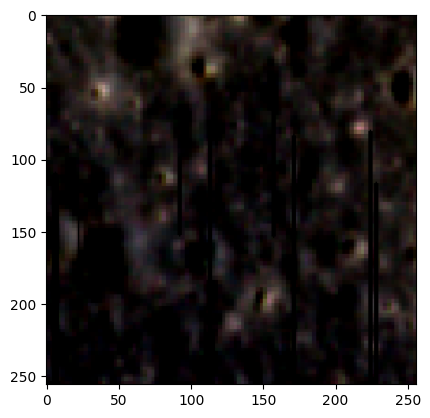

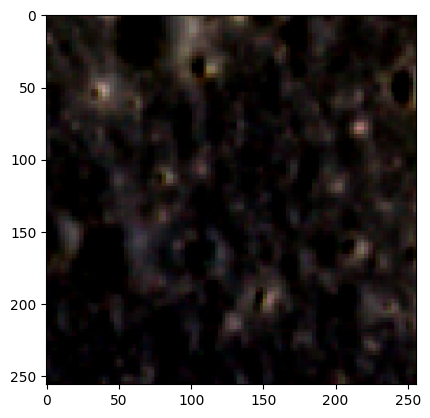

In [5]:
plt.imshow(x[0])
plt.show()
plt.imshow(y[0])
plt.show()

In [6]:
import random
indices=random.sample(range(0, len(x)), len(x)//5)
train_indices=[]
for i in range(len(x)):
  if i not in indices:
    train_indices.append(i)
print(len(train_indices),len(indices))

800 200


In [7]:
xtrain,xtest,ytrain,ytest=x[train_indices],x[indices],y[train_indices],y[indices]

In [8]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

class ImageImpaintingAlgorithms:
  def __init__(self):
    pass
  
  def BaiscAutoEncoder(self,input_size=(x,y,3)):

    input_img = Input(shape=(256, 256, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3,3), activation="relu",padding="same")(x)
    enc=MaxPooling2D((2,2) , padding="same")(x)


    x = Conv2D(128, (3, 3), activation='relu', padding='same')(enc)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.summary()
    return autoencoder
  

  def __encoder(self,inputs, filters=32, dprob=0.3, pooling=True):
    conv = Conv2D(filters, 
                  3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(filters, 
                  3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
  
    conv = BatchNormalization()(conv, training=False)
    if (pooling==True):
        next = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next = conv
    skip_conn = conv    
    return next, skip_conn
  
  def __decoder(self,prev_layer, skip_layer, filters=32):
    up = Conv2DTranspose(
                 filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer)
    merge = concatenate([up, skip_layer], axis=3)
    conv = Conv2D(filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(filters,
                 3, 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv


  
  def UNET(self,input_size=(128, 128, 3), filters=32, n_classes=3):
    inputs = Input(input_size)
    e1 = self.__encoder(inputs, filters,dprob=0, pooling=True)
    e2 = self.__encoder(e1[0],filters*2,dprob=0, pooling=True)
    e3 = self.__encoder(e2[0], filters*4,dprob=0, pooling=True)
    e4 = self.__encoder(e3[0], filters*8,dprob=0.3, pooling=True)
    e5 = self.__encoder(e4[0], filters*16, dprob=0.3, pooling=False) 
    
    d1 = self.__decoder(e5[0], e4[1],  filters * 8)
    d2 = self.__decoder(d1, e3[1],  filters * 4)
    d3 = self.__decoder(d2, e2[1],  filters * 2)
    d4 = self.__decoder(d3, e1[1], filters)

    conv9 = Conv2D(filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(d4)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


In [9]:
x=[]
y=[]

In [10]:
Algorithms=ImageImpaintingAlgorithms()

autoencoder=Algorithms.BaiscAutoEncoder(input_size=(256,256,3))
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),loss="mean_squared_error", metrics=['accuracy'])
results = autoencoder.fit(xtrain, ytrain, batch_size=50, epochs=20, validation_data=(xtest, ytest))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928 

In [11]:
x=[]
y=[]

In [11]:
xtrain=[]


In [12]:
constructed_imgs=autoencoder.predict(xtest)

7/7 [==============================] - 2s 114ms/step


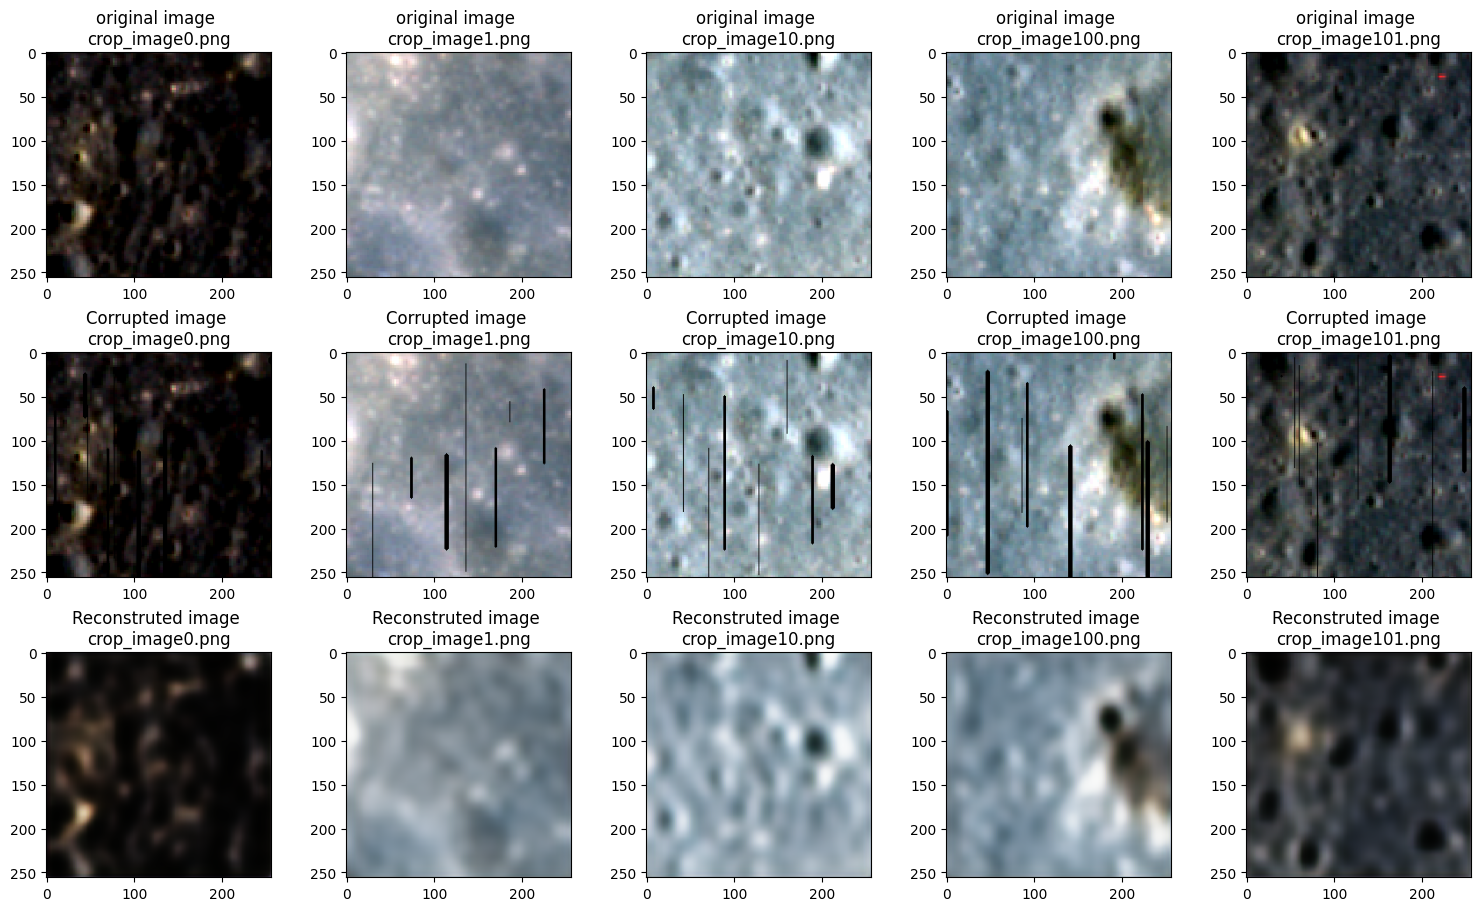

In [13]:
fig, axs = plt.subplots(3, 5,figsize=(15,9),constrained_layout=True)
for i in range(5):
  axs[0,i].set_title("original image \n{}".format(labels[i]))
  axs[0,i].imshow(ytest[i])
  axs[1,i].set_title("Corrupted image \n{}".format(labels[i]))
  axs[1,i].imshow(xtest[i])
  axs[2,i].set_title("Reconstruted image \n{}".format(labels[i]))
  axs[2,i].imshow(constructed_imgs[i])